# [Bike Sharing Demand](https://bit.ly/3gepGaZ)


### Celem tej lekcji jest zrobienie predykcji popytu na rowery dla danej stacji o danej godzinie.

In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.model_selection import GroupKFold

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from scikitplot.estimators import plot_learning_curve

import xgboost as xgb

from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

/Users/mmastalerczyk/opt/anaconda3/envs/umap2/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.
    """
    return np.sqrt(np.mean((np.power(np.log(np.array(actual)+1) - 
            np.log(np.array(predicted)+1), 2))))


## Wczytujemy dane
Sprawdzamy podstawowe dane.

In [4]:
train = pd.read_csv('../input/bike.train.csv')
train.shape

(10886, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
train.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
6638,2012-03-13 21:00:00,1,0,1,1,23.78,27.275,56,7.0015,44,200,244
7975,2012-06-12 16:00:00,2,0,1,2,27.06,29.545,89,19.0012,30,209,239
5915,2012-02-02 16:00:00,1,0,1,1,18.86,22.725,55,19.0012,18,211,229
8050,2012-06-15 19:00:00,2,0,1,1,28.70,31.820,42,11.0014,98,369,467
5894,2012-02-01 19:00:00,1,0,1,1,22.14,25.760,52,19.0012,20,315,335
1466,2011-04-06 23:00:00,2,0,1,1,18.86,22.725,41,19.9995,11,29,40
10710,2012-12-12 16:00:00,4,0,1,2,13.94,16.665,46,8.9981,19,310,329
5138,2011-12-08 04:00:00,4,0,1,2,9.84,9.850,60,31.0009,0,2,2
1726,2011-04-17 20:00:00,2,0,0,1,21.32,25.000,36,12.9980,44,97,141
3943,2011-09-15 08:00:00,3,0,1,1,26.24,30.305,73,8.9981,27,364,391


## **count** - zmienna docelowa
Również warto zwrócić uwagę, że **casual** + **registered** = **count** (chociaż warto sprawdzić, czy faktycznie tak jest).

In [7]:
train[ train['casual'] + train['registered'] != train['count'] ].shape

(0, 12)

Zgadza się :). To teraz sprawdźmy rozkład.

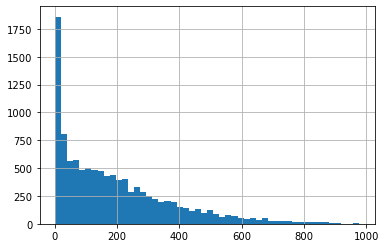

In [8]:
train['count'].hist(bins=50);

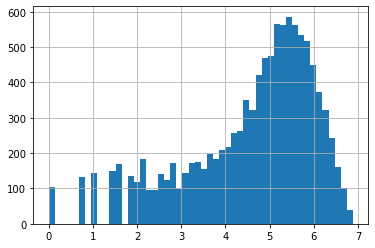

In [9]:
np.log( train['count'] ).hist(bins=50);

## Basic Model

In [10]:
X = train[ ['season'] ].values
y = train['count'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

1.5691983019475926

## Feature Engineering #1
Wśród kolumn mamy zmienną `datetime`, którą warto rozbić na poszczególne elementy (rok, miesiąc, godzina itd).

In [11]:
train['datetime'] = pd.to_datetime( train['datetime'] )

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute

train['dayofweek'] = train['datetime'].dt.dayofweek
train['weekofyear'] = train['datetime'].dt.weekofyear
train['weekend'] = train['dayofweek'].map(lambda x: int(x in [5,6]) )
train['dayofyear'] = train['datetime'].dt.dayofyear

/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_76922/87543674.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['weekofyear'] = train['datetime'].dt.weekofyear


## Walidacja
Tworzymy kilka funkcji.

In [12]:
def get_feats(df):
    black_list = ['count', 'count_log', 'registered', 'registered_log', 'casual', 'casual_log']
    feats = df.select_dtypes(include=[np.number]).columns
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats

def custom_validation(df, feats, target_variable='count', n_folds=3):
    X = df[feats].values
    y = df[target_variable].values

    groups = train['month'].values
    group_kfold = GroupKFold(n_splits=n_folds)
    
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        yield X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        
def run_cv(train, feats, model, folds=3):
    scores = []
    for X_train, X_test, y_train, y_test in custom_validation(train, feats):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = rmsle(y_test, y_pred)

        scores.append(score)
        
    return np.mean(scores), np.std(scores)

## Decision Tree

In [13]:
run_cv(train, get_feats(train), DecisionTreeRegressor(max_depth=5, random_state=2019))

(0.6245319390672505, 0.004588918406066621)

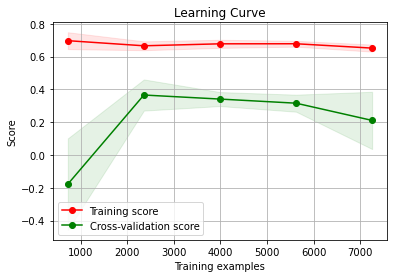

In [14]:
X, y = train[get_feats(train)], train['count']

plot_learning_curve(DecisionTreeRegressor(max_depth=5, random_state=2019), X, y, cv=3);

## Random Forest

In [15]:
run_cv(train, get_feats(train), RandomForestRegressor(max_depth=5, n_estimators=20, random_state=2019))

(0.6084345104534058, 0.0078401758788889)

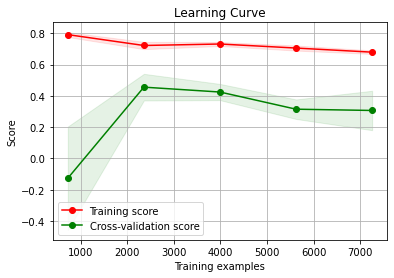

In [16]:
X, y = train[get_feats(train)], train['count']

plot_learning_curve(RandomForestRegressor(max_depth=5, n_estimators=20, random_state=2019), X, y, cv=3);

Ta krzywa nie wygląda idealnie, próbujemy dalej...

## Feature Engineering #2

### Aggregation
Zróbmy teraz kilka agregacji (grupowanie) po kluczu, np. pogrupujmy wg `year`.

In [17]:
median_year = train[ ['year', 'count'] ].groupby(['year']).median().to_dict()['count']
train['year'].map(lambda x: median_year[x]).head()

0    111.0
1    111.0
2    111.0
3    111.0
4    111.0
Name: year, dtype: float64

In [18]:
agg_feats = ['year', 'hour']
agg_func = np.median

agg_hour_year = train[ agg_feats + ['count'] ].groupby(agg_feats).agg(agg_func).to_dict()['count']
new_feat = '{0}_{1}'.format( agg_func.__name__, "_".join(agg_feats) )
train[agg_feats].apply(lambda x: agg_hour_year[ tuple(dict(x).values()) ], axis=1).head()

0    32.0
1    16.0
2    10.0
3     6.0
4     5.0
dtype: float64

### Run aggregation
Teraz zrobimy agregację po dwóch zmiennych jednocześnie.

In [19]:
agg_feats = [ 
    ['hour', 'year'],
    ['hour', 'season'],
    ['hour', 'month'],
]

for agg_feat in tqdm(agg_feats):
    for agg_func in [np.mean, np.median, np.sum, np.std]:
        dict_agg = train[ agg_feat + ['count'] ].groupby(agg_feat).agg(agg_func).to_dict()['count']
        new_feat = 'agg_{0}_{1}'.format( agg_func.__name__, "_".join(agg_feat) )

        default_dict_val = agg_func( list(dict_agg.values()))
        default_dict_agg = defaultdict(lambda: default_dict_val, dict_agg)

        train[new_feat] = train[agg_feat].apply(lambda x: dict_agg[ tuple(dict(x).values()) ], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.84it/s]


In [20]:
agg_feats = [feat for feat in  train.columns if feat.startswith('agg_') ]
agg_feats

['agg_mean_hour_year',
 'agg_median_hour_year',
 'agg_sum_hour_year',
 'agg_std_hour_year',
 'agg_mean_hour_season',
 'agg_median_hour_season',
 'agg_sum_hour_season',
 'agg_std_hour_season',
 'agg_mean_hour_month',
 'agg_median_hour_month',
 'agg_sum_hour_month',
 'agg_std_hour_month']

In [21]:
run_cv(train, get_feats(train), RandomForestRegressor(max_depth=5, n_estimators=20, random_state=2019))

(0.6081012568681, 0.024866551028755315)

Wygląda podobnie ~**0.61**. Co prawda "napracowaliśmy się" znacznie więcej, ale próbujemy dalej.

## Log2 (count)
Zróbmy teraz transformację logarytmiczną zmiennej docelowej. Dodatkowo, aby nasza zmienna była bardziej symetryczna, przed logarytmowaniem dodamy do niej stałą wartość.

In [22]:
feats = get_feats(train)

X = train[feats].values

groups = train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)

count = train['count'].values
offset_log = 6
count_log = np.log2( count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
    model = DecisionTreeRegressor(max_depth=5, random_state=2019)
    model.fit(X[train_idx], count_log[train_idx])
    count_log_pred = model.predict(X[test_idx])
    
    count_pred = np.exp2( count_log_pred ) - offset_log

    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.5856258021778559, 0.020331896927206772)

Wygląda lepiej: ~**0.59** vs ~**0.61** (transformacja logarytmiczna pomogła).

## log2(registered) & log2(casual)

Teraz postawimy kolejny krok i wykonamy transformację logarytmiczną dla kolumn `registered` i `casual`, a następnie zbudujemy oddzielny model prognozujący każdą z tych kolumn. Na koniec zrobimy predykcję i zsumujemy je ze sobą.

In [23]:
feats = get_feats(train)

groups = train['datetime'].dt.month.values
group_kfold = GroupKFold(n_splits=3)
    
X = train[feats].values
offset_log = 3

registered = train['registered'].values
registered_log = np.log2(registered + offset_log)

casual = train['casual'].values
casual_log = np.log2(casual + offset_log)

count = train['count'].values
count_log = np.log2(count + offset_log)

scores = []
for train_idx, test_idx in group_kfold.split(X, count, groups):
    model = DecisionTreeRegressor(max_depth=5, random_state=2019)
    model.fit(X[train_idx], registered_log[train_idx])
    registered_log_pred = model.predict(X[test_idx])
    registered_pred = np.exp2(registered_log_pred) - offset_log
    
    model = DecisionTreeRegressor(max_depth=5)
    model.fit(X[train_idx], casual_log[train_idx])
    casual_log_pred = model.predict(X[test_idx])
    casual_pred = np.exp2(casual_log_pred) - offset_log
    
    count_pred = registered_pred + casual_pred
    
    score = rmsle(count[test_idx], count_pred)
    scores.append(score)

np.mean(scores), np.std(scores)

(0.5619351616859883, 0.01840269129197032)

Wygląda lepiej: **0.56** vs **0.59**.

Zastosujemy teraz bardziej zaawansowane modele: **Random Forest** i **XGBoost**. Tylko najpierw wrzucimy powyższy kod do funkcji, żeby nie trzeba było go powtarzać.

In [24]:
def run_log_registered_casual(train, model_class, model_params={}, feats=None, folds=3):
    if feats is None:
        feats = get_feats(train)

    groups = train['datetime'].dt.month.values
    group_kfold = GroupKFold(n_splits=3)

    X = train[feats].values
    offset_log = 3

    registered = train['registered'].values
    registered_log = np.log2(registered + offset_log)

    casual = train['casual'].values
    casual_log = np.log2(casual + offset_log)

    count = train['count'].values
    count_log = np.log2(count + offset_log)

    scores = []
    for train_idx, test_idx in group_kfold.split(X, count, groups):
        model = model_class(**model_params)
        model.fit(X[train_idx], registered_log[train_idx])
        registered_log_pred = model.predict(X[test_idx])
        registered_pred = np.exp2(registered_log_pred) - offset_log

        model = model_class(**model_params)
        model.fit(X[train_idx], casual_log[train_idx])
        casual_log_pred = model.predict(X[test_idx])
        casual_pred = np.exp2(casual_log_pred) - offset_log

        count_pred = registered_pred + casual_pred

        score = rmsle(count[test_idx], count_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

## Random Forest

In [25]:
rf_params = {
    'n_estimators': 100, 
    'max_depth': 15, 
    'random_state': 0, 
    'min_samples_split' : 5
}
run_log_registered_casual(train, RandomForestRegressor, rf_params )

(0.3566502685231591, 0.007714002957999988)

## XGBoost

In [26]:
xgb_params = {
    'max_depth': 10, 
    'n_estimators': 100, 
    'random_state': 0,
    'learning_rate': 0.3,
    'objective': 'reg:squarederror'
}
run_log_registered_casual(train, xgb.XGBRegressor, xgb_params )

(0.37092221748081267, 0.00916620161694113)

`Random Forest` i `XGBoost` zbudowały znacznie lepszy model niż `Decision Tree`:

RF ~**0.36** i XGB ~**0.37** vs ~**0.56**

Następnym krokiem (który ma sens dla Kaggle, ale niekoniecznie na produkcji) jest połączenie dwóch lub więcej modeli, wtedy jest szansa jeszcze "trochę" poprawić jakość modelu.

## Przydatne linki:
1. [Webinar: Bike Sharing Demand](https://bit.ly/3mSnNlE)
2. [Kaggle Bike Sharing Demand Prediction – How I got in top 5 percentile of participants?](https://bit.ly/32lrIxE)
3. How to finish top 10 percentile in Bike Sharing Demand Competition In Kaggle? [part1](https://bit.ly/3wZxTWq) & [part2](https://bit.ly/3e92TuD)
4. Github: [Kaggle competition: Predict Bike Sharing Demand](https://bit.ly/3uUQ6CI)

